## 024 Compare binomial and Poisson regression models (single subject)

Date: 08.Aug.2022

### Purpose

Compare the performance of binomial and poisson regression.

### Outline of Plan

1. Copy BiasedCEC, HeuCEC, RWCEC, A0BCEC, A1BCEC, A2BCEC from NB#022.
2. Implement a Poisson regression model to replace Binomial model.

### What we did in this notebook

1. Poisson version of Biased, Heu and RW CEC-only models
2. Model comparison and posterior visualization.

### Overall conclusions
1. It looks like the posteriors for Poisson models are actually really bad. Better to stick with Binomial model.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
from scipy.special import expit
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

from latest_models_binomial import RetroPrototype

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Define null model classes

In [8]:
class Binom_BiasedCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Biased_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Biased'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def right_action_probs(self, actions, rewards, *args):
        
        sample_bias, weight_zero, weight_one = args

        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        probs = at.repeat(sample_bias, t_actions.shape[0])
        pred_cravings = weight_zero + weight_one*t_rewards

        return probs[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_bias = pm.Normal('untr_bias', mu=0, sigma=1)
        bias = pm.Deterministic('bias', pm.math.invlogit(untr_bias))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return bias, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Binomial('craving_like', n=50, p=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [9]:
class Binom_HeuCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Heuristic_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Heuristic'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def add_eps(self, st, a, eps_t, eps):
        return aesara.ifelse.ifelse(
                at.eq(st, 1),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    eps,
                    1-eps
                ),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    1-eps,
                    eps
                )
            )
    
    def right_action_probs(self, actions, rewards, strat, *args):
        
        sample_eps, weight_zero, weight_one = args

        t_strat = at.as_tensor_variable(strat, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')

        # Compute the Qs values
        t_eps = at.as_tensor_variable(np.asarray(1, 'float64'))
        t_eps, updates = aesara.scan(
            fn=self.add_eps,
            sequences=[t_strat, t_actions],
            outputs_info=t_eps,
            non_sequences=[sample_eps])
        
        pred_cravings = weight_zero + weight_one*t_rewards

        return t_eps[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_eps = pm.Normal('untr_eps', mu=0, sigma=1)
        eps = pm.Deterministic('eps', pm.math.invlogit(untr_eps))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return eps, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        strat = np.zeros(len(act))
        for i, a in enumerate(act):
            if i < 2:
                continue
            should_switch = np.all(np.array([rew[i-2]==rew[i-1], rew[i-1]==0]), axis=0)
            do_switch = act[i-1]!=act[i]
            strat[i] = should_switch==do_switch
        strat = strat.astype(int)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, strat, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Binomial('craving_like', n=50, p=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [10]:
class Binom_RWCEC():
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'RW_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        return Qs

    def right_action_probs(self, actions, rewards, beta, *args):
        alpha, weight_zero, weight_one = args
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.invlogit(loopvals[:, 2])
        t_pred_craving = weight_zero + weight_one*t_rewards

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  pm.math.invlogit(t_pred_craving)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Binomial('craving_like', n=50, p=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [17]:
class Poisson_BiasedCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Poisson_Biased_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Biased'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def right_action_probs(self, actions, rewards, *args):
        
        sample_bias, weight_zero, weight_one = args

        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        probs = at.repeat(sample_bias, t_actions.shape[0])
        pred_cravings = weight_zero + weight_one*t_rewards

        return probs[1:],  pred_cravings
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_bias = pm.Normal('untr_bias', mu=0, sigma=1)
        bias = pm.Deterministic('bias', pm.math.invlogit(untr_bias))
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return bias, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Poisson('craving_like', mu=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [18]:
class Poisson_HeuCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Poisson_Heuristic_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Heuristic'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def add_eps(self, st, a, eps_t, eps):
        return aesara.ifelse.ifelse(
                at.eq(st, 1),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    eps,
                    1-eps
                ),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    1-eps,
                    eps
                )
            )
    
    def right_action_probs(self, actions, rewards, strat, *args):
        
        sample_eps, weight_zero, weight_one = args

        t_strat = at.as_tensor_variable(strat, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')

        # Compute the Qs values
        t_eps = at.as_tensor_variable(np.asarray(1, 'float64'))
        t_eps, updates = aesara.scan(
            fn=self.add_eps,
            sequences=[t_strat, t_actions],
            outputs_info=t_eps,
            non_sequences=[sample_eps])
        
        pred_cravings = weight_zero + weight_one*t_rewards

        return t_eps[1:],  pred_cravings
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_eps = pm.Normal('untr_eps', mu=0, sigma=1)
        eps = pm.Deterministic('eps', pm.math.invlogit(untr_eps))
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return eps, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        strat = np.zeros(len(act))
        for i, a in enumerate(act):
            if i < 2:
                continue
            should_switch = np.all(np.array([rew[i-2]==rew[i-1], rew[i-1]==0]), axis=0)
            do_switch = act[i-1]!=act[i]
            strat[i] = should_switch==do_switch
        strat = strat.astype(int)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, strat, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Poisson('craving_like', mu=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [19]:
class Poisson_RWCEC():
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Poisson_RW_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        return Qs

    def right_action_probs(self, actions, rewards, beta, *args):
        alpha, weight_zero, weight_one = args
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.invlogit(loopvals[:, 2])
        t_pred_craving = weight_zero + weight_one*t_rewards

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Poisson('craving_like', mu=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

## EVRPE-CEC mixed models

In [49]:
class Binom_MixedPrototype(ABC):
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, cec_weight, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        # Note that the second parameter is always the weight assigned to the cue-induced effect
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.math.invlogit(loopvals[:, 2]) ## RETROPROTOTYPE VERSION ##
        t_pred_craving = pm.invlogit(loopvals[:, 2] + cec_weight*t_rewards) ## MIXEDPROTOTYPE VERSION ##

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Binomial('craving_like', n=50, p=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [50]:
class A0BCEC(Binom_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_0step_CEC'
        self.type = 'active_lr'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [51]:
class A1BCEC(Binom_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_1stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*pe + w4*Qs[5]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, mod


In [52]:
class A2BCEC(Binom_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_2stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod


In [53]:
class A1BMeanCEC(Binom_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_1stepMean_CEC'
        self.type = 'active_lr'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*(Qs[a]+Qs[3])/2 + w2*(pe+Qs[5])/2
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [54]:
class A2BMeanCEC(Binom_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_2stepMean_CEC'
        self.type = 'active_lr'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*(Qs[a] + Qs[3] + Qs[4])/3 + w2*(pe + Qs[5] + Qs[6])/3
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [42]:
class Poisson_MixedPrototype(ABC):
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, cec_weight, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        # Note that the second parameter is always the weight assigned to the cue-induced effect
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.math.invlogit(loopvals[:, 2]) ## RETROPROTOTYPE VERSION ##
        t_pred_craving = loopvals[:, 2] + cec_weight*t_rewards ## MIXEDPROTOTYPE VERSION ##

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            prob_craving = pm.Deterministic('prob_craving', craving_pred[self.craving_inds-1])
            craving_like = pm.Poisson('craving_like', mu=prob_craving, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [43]:
class Poisson_A0BCEC(Poisson_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'Poisson_A_RW_0step_CEC'
        self.type = 'active_lr'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [44]:
class Poisson_A1BCEC(Poisson_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'Poisson_A_RW_1stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*pe + w4*Qs[5]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=25, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, mod


In [45]:
class Poisson_A2BCEC(Poisson_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'Poisson_A_RW_2stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod


In [46]:
class Poisson_A1BMeanCEC(Poisson_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'Poisson_A_RW_1stepMean_CEC'
        self.type = 'active_lr'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*(Qs[a]+Qs[3])/2 + w2*(pe+Qs[5])/2
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [47]:
class Poisson_A2BMeanCEC(Poisson_MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'Poisson_A_RW_2stepMean_CEC'
        self.type = 'active_lr'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*(Qs[a] + Qs[3] + Qs[4])/3 + w2*(pe + Qs[5] + Qs[6])/3
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=25, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


## Fit models

In [55]:
save_path_nb24 = f'{model_functions_path}/exploration/24_trace_output/'
biasedcec = Binom_BiasedCEC(longform, df_summary, project_dir, save_path_nb24)
heucec = Binom_HeuCEC(longform, df_summary, project_dir, save_path_nb24)
rwcec = Binom_RWCEC(longform, df_summary, project_dir, save_path_nb24)
biasedcec_poiss = Poisson_BiasedCEC(longform, df_summary, project_dir, save_path_nb24)
heucec_poiss = Poisson_HeuCEC(longform, df_summary, project_dir, save_path_nb24)
rwcec_poiss = Poisson_RWCEC(longform, df_summary, project_dir, save_path_nb24)
a0bcec = A0BCEC(longform, df_summary, project_dir, save_path_nb24)
a1bcec = A1BCEC(longform, df_summary, project_dir, save_path_nb24)
a2bcec = A2BCEC(longform, df_summary, project_dir, save_path_nb24)
a1bmeancec = A1BMeanCEC(longform, df_summary, project_dir, save_path_nb24)
a2bmeancec = A2BMeanCEC(longform, df_summary, project_dir, save_path_nb24)
a0bcec_poiss = Poisson_A0BCEC(longform, df_summary, project_dir, save_path_nb24)
a1bcec_poiss = Poisson_A1BCEC(longform, df_summary, project_dir, save_path_nb24)
a2bcec_poiss = Poisson_A2BCEC(longform, df_summary, project_dir, save_path_nb24)
a1bmeancec_poiss = Poisson_A1BMeanCEC(longform, df_summary, project_dir, save_path_nb24)
a2bmeancec_poiss = Poisson_A2BMeanCEC(longform, df_summary, project_dir, save_path_nb24)

In [57]:
for pid_num in [8]:
    for model in [biasedcec, heucec, rwcec, biasedcec_poiss, heucec_poiss, rwcec_poiss, a0bcec, a1bcec, a2bcec, a1bmeancec, a2bmeancec, a0bcec_poiss, a1bcec_poiss, a2bcec_poiss, a1bmeancec_poiss, a2bmeancec_poiss]:
        model.fit(pid_num, 'other')

PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [cec_weight]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'beta_log__': array(2.30258509), 'untr_alpha': array(0.), 'cec_weight': array(0.), 'weight_zero': array(0.), 'weight_one': array(25.), 'weight_two': array(0.), 'weight_three': array(0.), 'weight_four': array(0.), 'mod_log__': array(0.125)}

Initial evaluation results:
{'beta': -0.73, 'untr_alpha': -0.92, 'cec_weight': -0.92, 'weight_zero': -0.92, 'weight_one': -0.92, 'weight_two': -0.92, 'weight_three': -0.92, 'weight_four': -0.92, 'mod': -0.26, 'like': -98.61, 'craving_like': -inf}

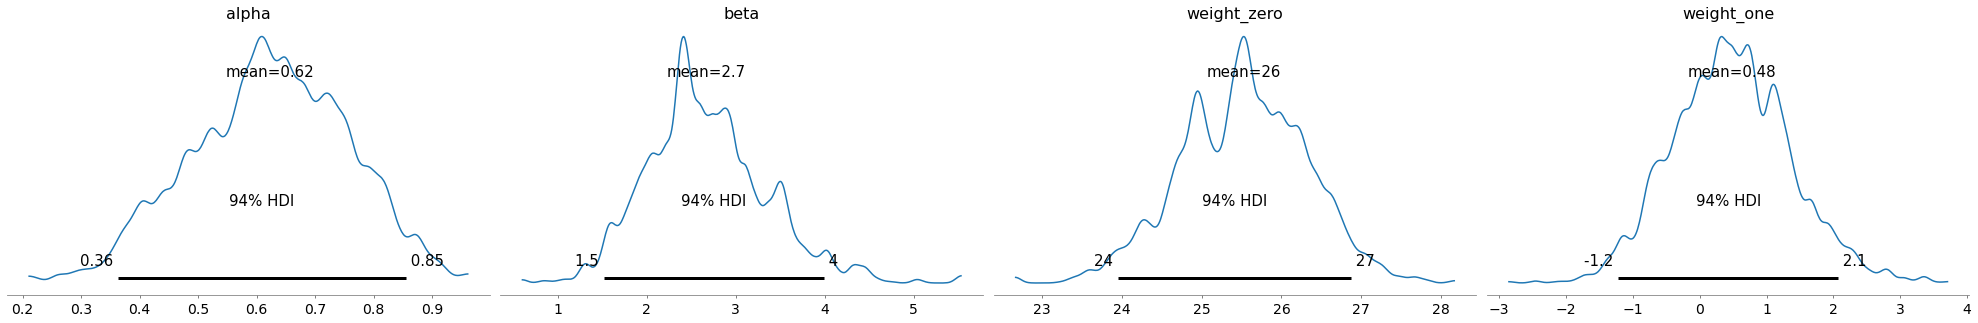

In [ ]:
az.plot_posterior(a2bmeancec_poiss.traces['other'][pid_list[pid_num]], var_names=['alpha', 'beta', 'weight_zero', 'weight_one'])
plt.tight_layout()

## Output posterior

In [ ]:
pid_num = 8

## Plotting utils

In [ ]:
def plot_ppc_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,4), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [ ]:
def plot_true_choices(samp_model, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), facecolor='w', edgecolor='k')
    pid_act = samp_model.longform[(samp_model.longform['PID']==samp_model.pid_list[pid_num]) & (samp_model.longform['Type']==block)]['Action'].values
    sns.scatterplot(x=np.arange(len(pid_act)), y=0.5*pid_act+0.25, s=100, color='red', ax=ax)
    ax.set_title(f'True choices')
    for rev in [12, 24, 36, 48]:
        ax.vlines(rev, 0, 1, color='black', linestyle='--')
    ax2 = ax.twinx()
    ax2.plot(samp_model.craving_inds, samp_model.cravings[b, pid_num], color='red', alpha=0.4)
    plt.tight_layout()
    plt.close()
    return fig

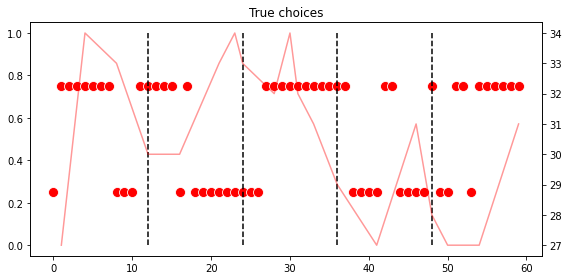

In [ ]:
plot_true_choices(biasedcec, 12, 'other')

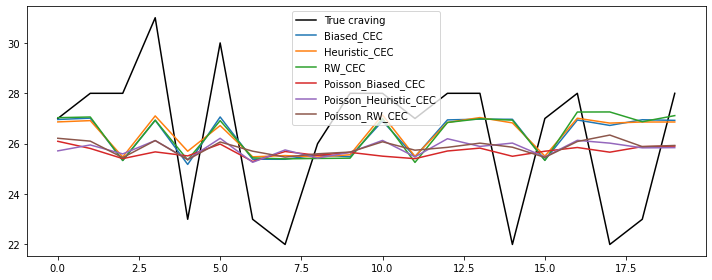

In [ ]:
plot_ppc_craving([
    biasedcec, heucec, rwcec,
    biasedcec_poiss, heucec_poiss, rwcec_poiss,
    a0bcec, a1bcec, a2bcec, a1bmeancec, a2bmeancec,
    a0bcec_poiss, a1bcec_poiss, a2bcec_poiss, a1bmeancec_poiss, a2bmeancec_poiss
], pid_num, 'other')

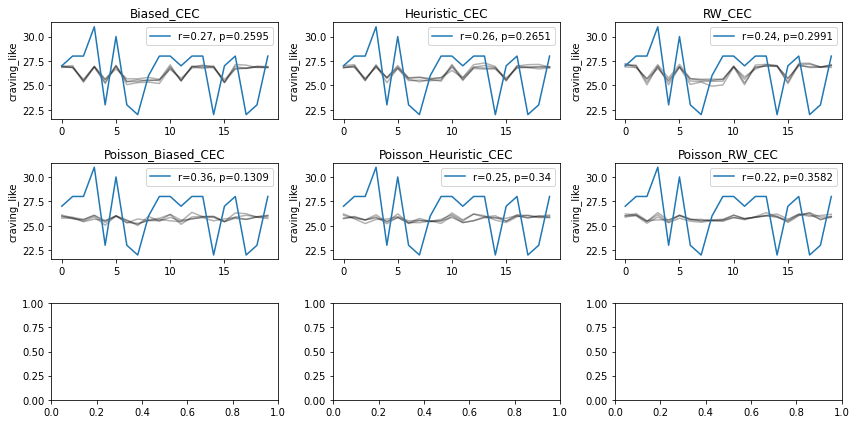

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(12,12), facecolor='w', edgecolor='k')

for i, model in enumerate([biasedcec, heucec, rwcec, biasedcec_poiss, heucec_poiss, rwcec_poiss]):
    rs = []
    ps = []
    for trace in model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like:
        r, p = stats.pearsonr(trace.mean(axis=0), model.cravings[1, pid_num])
        rs.append(r)
        ps.append(p)
        sns.lineplot(
            x=np.arange(len(model.cravings[1, pid_num])), 
            y=trace.mean(axis=0), ax=ax[i//3, i%3], 
            color='black', alpha=0.3)
    sns.lineplot(
        x=np.arange(len(model.cravings[1, pid_num])), 
        y=model.cravings[1, pid_num], 
        label=f'r={np.round(np.mean(rs), 2)}, p={np.round(np.mean(ps), 4)}', 
        ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(model.name)

plt.tight_layout()

## Derive MAP estimate of p vector and simulate binomial draws

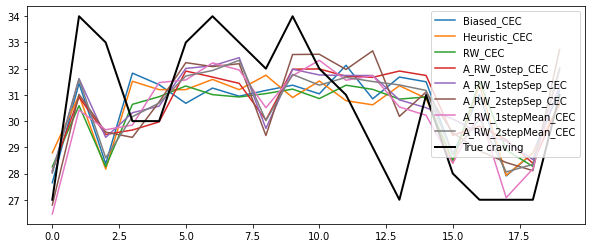

In [309]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,4), facecolor='w', edgecolor='k')
for chosen_model in [biasedcec, heucec, rwcec, a0bcec, a1bcec, a2bcec, a1bmeancec, a2bmeancec]:
    ax.plot(np.random.binomial(n=50,
        p=chosen_model.traces['other'][pid_list[pid_num]].posterior.prob_craving[0].values.mean(axis=0), 
        size=(100, 20)).mean(axis=0), label=chosen_model.name)
ax.plot(chosen_model.cravings[1, pid_num, :], label='True craving', color='black', lw=2)
ax.legend()

In [310]:
for chosen_model in [biasedcec, heucec, rwcec, a0bcec, a1bcec, a2bcec, a1bmeancec, a2bmeancec]:
    mean_ll = np.sum(stats.binom.logpmf(k=chosen_model.cravings[1, 8, :], 
        n=50, 
        p=chosen_model.traces['other'][pid_list[pid_num]].posterior.prob_craving[1].values.mean(axis=0)
    ))
    num_vars = len(chosen_model.traces['other'][pid_list[pid_num]].posterior.data_vars) - 2
    print(chosen_model.name, mean_ll, (-2*mean_ll)+(num_vars*np.log(20)))

Biased_CEC -63.85120597178758 136.68960876423714
Heuristic_CEC -63.53785188136639 136.06290058339476
RW_CEC -63.02755747377475 138.03804404176546
A_RW_0step_CEC -65.61760538454287 152.20533668396368
A_RW_1stepSep_CEC -65.84690382736851 158.65539811672292
A_RW_2stepSep_CEC -65.87405624845243 164.70116750599877
A_RW_1stepMean_CEC -65.23687860566717 151.44388312621228
A_RW_2stepMean_CEC -64.98279364001417 150.93571319490627


In [311]:
dics = []
for chosen_model in [biasedcec, heucec, rwcec, a0bcec, a1bcec, a2bcec, a1bmeancec, a2bmeancec]:
    lls = np.array([np.sum(stats.binom.logpmf(k=chosen_model.cravings[1, pid_num, :], n=50, p=samp_probs)) 
        for samp_probs in np.concatenate(chosen_model.traces['other'][pid_list[pid_num]].posterior.prob_craving, axis=0)])
    p_dic = 2*(lls - np.mean(lls))
    dic = -2*lls + 2*p_dic
    dics.append(dic.mean())
    # mean_ll = np.sum(stats.binom.logpmf(k=chosen_model.cravings[1, 8, :], 
    #     n=50, 
    #     p=chosen_model.traces['other'][pid_list[pid_num]].posterior.prob_craving[1].values.mean(axis=0)
    # ))
    # num_vars = len(chosen_model.traces['other'][pid_list[pid_num]].posterior.data_vars) - 2
    # print(chosen_model.name, mean_ll, (-2*mean_ll)+(num_vars*np.log(60)))
    print(chosen_model.name, dic.mean())

Biased_CEC 96.95762522612254
Heuristic_CEC 96.69048244115062
RW_CEC 96.91373594121329
A_RW_0step_CEC 96.46419674325216
A_RW_1stepSep_CEC 96.97978027549937
A_RW_2stepSep_CEC 97.74207319821184
A_RW_1stepMean_CEC 96.5418267924514
A_RW_2stepMean_CEC 96.71865767257101


(96.26419674325216, 97.84207319821184)

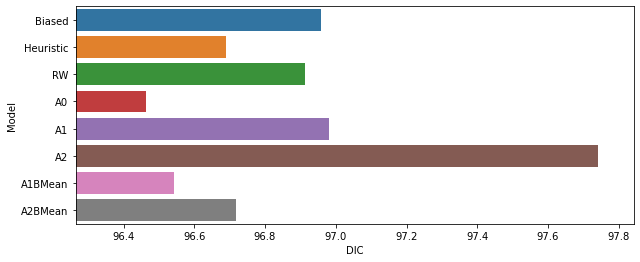

In [312]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

sns.barplot(data=pd.DataFrame({
    'Model': ['Biased', 'Heuristic', 'RW', 'A0', 'A1', 'A2', 'A1BMean', 'A2BMean'],
    'DIC': dics,
}), y='Model', x='DIC', ax=ax)

ax.set_xlim(np.min(dics)-0.2, np.max(dics)+0.1)


## Model comparison of EV and EVRPE

In [ ]:
biasedcec.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values.shape

(4, 1000, 20)

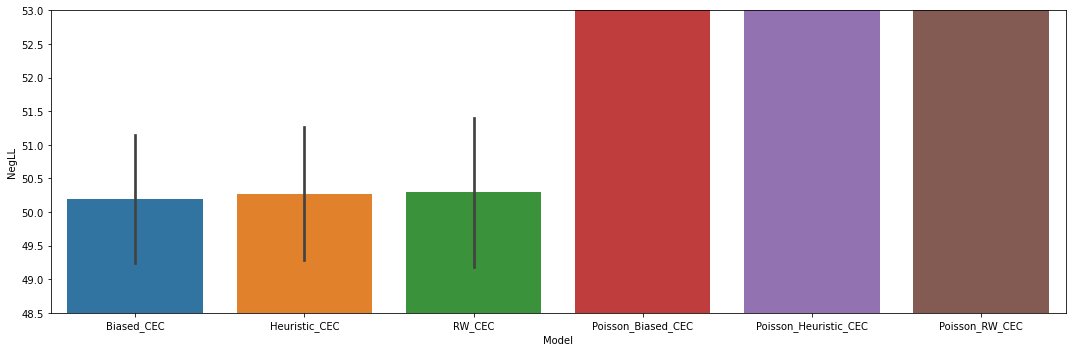

In [ ]:
model_names = []
lls = []
for model in [biasedcec, heucec, rwcec, biasedcec_poiss, heucec_poiss, rwcec_poiss, a0bcec, a0bcec_poiss, a1bcec_poiss, a2bcec_poiss, a1bmeancec_poiss, a2bmeancec_poiss]:
    for trace in model.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values:
        for samp in trace:
            model_names.append(model.name)
            lls.append(-samp.sum())

ll_df = pd.DataFrame({'Model': model_names, 'NegLL': lls})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
sns.barplot(data=ll_df, x='Model', y='NegLL', ci='sd', ax=ax)
ax.set_ylim(48.5,53)
plt.tight_layout()

In [ ]:
ll_df.groupby('Model').agg({'NegLL': ['mean', 'std']})

NegLL          
                            mean       std
Model                                     
Biased_CEC             50.192422  0.956299
Heuristic_CEC          50.275753  0.982575
Poisson_Biased_CEC     54.329624  0.581040
Poisson_Heuristic_CEC  54.347085  0.588666
Poisson_RW_CEC         54.313641  0.579244
RW_CEC                 50.292313  1.113168

In [30]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Biased_poisson': biasedcec_poiss.traces['other'][pid_list[pid_num]],
        'Heuristic_poisson': heucec_poiss.traces['other'][pid_list[pid_num]],
        'RWCEC_poisson': rwcec_poiss.traces['other'][pid_list[pid_num]],
        'Active0CEC': a0bcec.traces['other'][pid_list[pid_num]],
        'Active1CEC': a1bcec.traces['other'][pid_list[pid_num]],
        'Active2CEC': a2bcec.traces['other'][pid_list[pid_num]],
        'Active0CEC_poisson': a0bcec_poiss.traces['other'][pid_list[pid_num]],
        'Active1CEC_poisson': a1bcec_poiss.traces['other'][pid_list[pid_num]],
        'Active2CEC_poisson': a2bcec_poiss.traces['other'][pid_list[pid_num]],
        'Active0BMeanCEC': a0bmeancec.traces['other'][pid_list[pid_num]],
        'Active1BMeanCEC': a1bmeancec.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Biased,0,-50.838141,1.186390,0.000000,1.0,1.438402,0.000000,False,log
Heuristic,1,-50.957793,1.258930,0.119652,0.0,1.478902,0.109937,False,log
RWCEC,2,-51.018731,1.323696,0.180590,0.0,1.494853,0.090085,False,log
RWCEC_poisson,3,-54.421761,0.208619,3.583621,0.0,0.565113,1.176713,False,log
Biased_poisson,4,-54.432134,0.198846,3.593993,0.0,0.573158,1.205113,False,log
Heuristic_poisson,5,-54.450312,0.200600,3.612171,0.0,0.576683,1.214596,False,log


<AxesSubplot:xlabel='Log'>

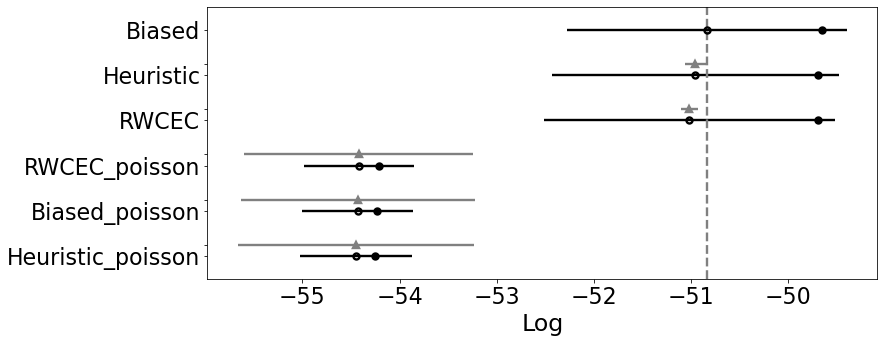

In [31]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [32]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Biased_poisson': biasedcec_poiss.traces['other'][pid_list[pid_num]],
        'Heuristic_poisson': heucec_poiss.traces['other'][pid_list[pid_num]],
        'RWCEC_poisson': rwcec_poiss.traces['other'][pid_list[pid_num]],
        # 'Active0': a0b.traces['other'][pid_list[pid_num]],
        # 'Active1': a1b.traces['other'][pid_list[pid_num]],
        # 'Active2': a2b.traces['other'][pid_list[pid_num]],
        # 'Active0CEC': a0bcec.traces['other'][pid_list[pid_num]],
        # 'Active1CEC': a1bcec.traces['other'][pid_list[pid_num]],
        # 'Active2CEC': a2bcec.traces['other'][pid_list[pid_num]]
    },
    ic='waic',
    var_name='like'
)
model_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
RWCEC,0,-28.133168,1.405215,0.000000,9.444964e-01,4.549077,0.000000,False,log
RWCEC_poisson,1,-28.205789,1.478706,0.072621,9.322562e-16,4.549860,0.015699,False,log
Heuristic,2,-36.349986,0.892404,8.216818,0.000000e+00,3.006161,3.824723,False,log
Heuristic_poisson,3,-36.383529,0.922518,8.250361,1.006253e-17,2.995751,3.823392,False,log
Biased_poisson,4,-38.695656,0.901471,10.562488,5.550364e-02,2.343357,4.552608,False,log
Biased,5,-38.743457,0.947764,10.610289,0.000000e+00,2.336024,4.550715,False,log


<AxesSubplot:xlabel='Log'>

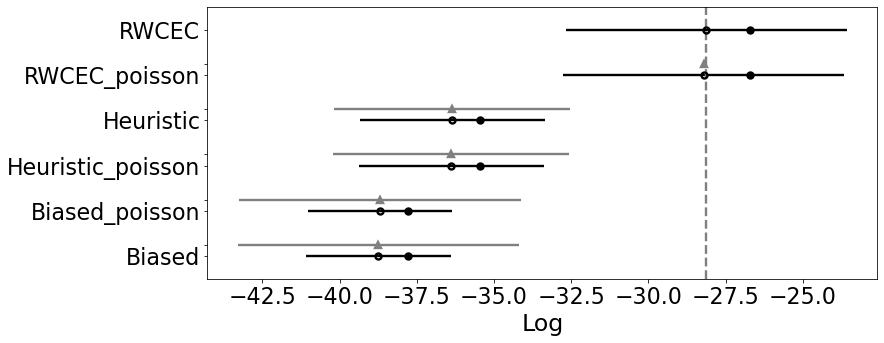

In [33]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))